In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import mean_absolute_percentage_error as mape
import shap, datetime, warnings
from great_tables import GT, md, html, style, loc
warnings.filterwarnings('ignore')

In [45]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [46]:
df

,date,ticker,Article Count_cum04_lag01,Article Count_cum16_lag01,Article Count_cum48_lag01,Article Count_cum96_lag01,Article Count_lag01,BNO_Change_High-Low,BNO_Change_High-Low_lag01,BNO_Change_High-Low_ma04,...,v42.8; SCOREDVALUE; fairness_sent_cum04_lag01,v42.8; SCOREDVALUE; fairness_sent_cum16_lag01,v42.8; SCOREDVALUE; fairness_sent_cum48_lag01,v42.8; SCOREDVALUE; fairness_sent_cum96_lag01,v42.8; SCOREDVALUE; fairness_sent_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum04_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum16_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum48_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum96_lag01,v42.9; SCOREDVALUE; loyalty_sent_lag01
0,2018-01-02 09:45:00,AAL,1,6,6,6,0,-0.035,0.020,0.01000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,2018-01-02 09:45:00,ALGT,0,0,0,0,0,-0.035,0.020,0.01000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,2018-01-02 09:45:00,ALK,0,3,5,5,0,-0.035,0.020,0.01000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,2018-01-02 09:45:00,DAL,0,1,1,1,0,-0.035,0.020,0.01000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,2018-01-02 09:45:00,JBLU,1,3,3,3,0,-0.035,0.020,0.01000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337783,2025-05-30 15:45:00,ALK,0,0,4,13,0,-0.020,0.015,0.00875,...,0.0,0.000000,-0.139706,-0.133636,0.0,0.0,0.000000,-0.067318,0.075841,0.0
337784,2025-05-30 15:45:00,DAL,0,4,7,11,0,-0.020,0.015,0.00875,...,0.0,-0.039292,0.056338,-0.185764,0.0,0.0,0.065506,0.186295,0.109351,0.0
337785,2025-05-30 15:45:00,JBLU,0,2,5,20,0,-0.020,0.015,0.00875,...,0.0,0.013177,0.021646,0.389782,0.0,0.0,0.052000,0.107777,0.615597,0.0
337786,2025-05-30 15:45:00,LUV,0,0,1,11,0,-0.020,0.015,0.00875,...,0.0,0.000000,0.028658,-0.189179,0.0,0.0,0.000000,0.042602,0.175897,0.0


In [47]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
sentiment_cols_no_llm = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [48]:
# Define the different sets of features to try
feature_sets = {
    'time_only': time_cols,
    'sentiment_only': sentiment_cols,
    'self_finance_only': self_finance_vars,
    'finance_only': finance_vars,
    'finance_time': finance_vars + time_cols,
    'all': sentiment_cols + finance_vars + time_cols 
}

all_no_llm = sentiment_cols_no_llm + finance_vars + time_cols 

In [49]:
for feature_set in feature_sets:
    print(f"{feature_set}: {len(feature_sets[feature_set])} features")

time_only: 26 features
sentiment_only: 750 features
self_finance_only: 160 features
finance_only: 800 features
finance_time: 826 features
all: 1576 features


In [50]:
y_cols = ['Volume']
y = df[y_cols]

In [51]:
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [52]:
models = ['OLS', 'LASSO', 'NeuralNet', 'LightGBM']

In [53]:
predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [54]:
for m in models:
    for feature_set in feature_sets:
        model = pickle.load(open(f'../../output/models/{m}/{m}_{feature_set}.pkl', 'rb'))

        x_cols = feature_sets[feature_set]
        x = df[x_cols]
        x_train = x[:split_val]
        x_val   = x[split_val:split_test]
        x_test  = x[split_test:]

        # Normalize the features to [0,1]
        sc2 = MinMaxScaler(feature_range=(0, 1))

        x_train = sc2.fit_transform(x_train)
        x_val   = sc2.transform(x_val)
        x_test  = sc2.transform(x_test)

        p1 = model.predict(x_val)
        p2 = model.predict(x_test)
        p = np.concatenate((p1, p2), axis=0)

        predictions[f'Predicted ({m}) ({feature_set})'] = p

# Add the tuned and retrained models as well
for desc in ['all_tuned', 'all_tuned_retrained']:
    model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_{desc}.pkl', 'rb'))

    x_cols = feature_sets['all']
    x = df[x_cols]
    x_train = x[:split_val]
    x_val   = x[split_val:split_test]
    x_test  = x[split_test:]

    # Normalize the features to [0,1]
    sc2 = MinMaxScaler(feature_range=(0, 1))

    x_train = sc2.fit_transform(x_train)
    x_val   = sc2.transform(x_val)
    x_test  = sc2.transform(x_test)

    p1 = model.predict(x_val)
    p2 = model.predict(x_test)
    p = np.concatenate((p1, p2), axis=0)

    predictions[f'Predicted (LightGBM) ({desc})'] = p

In [55]:
# Add the baseline
p = pickle.load(open(f'../../output/models/baseline predictions.pkl', 'rb'))
predictions[f'Predicted Baseline'] = p

In [56]:
# Sensitivity (no LLM variables)
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_all_no_llm.pkl', 'rb'))

x_cols = all_no_llm
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]
sc2 = MinMaxScaler(feature_range=(0, 1))
x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
p1 = model.predict(x_val)
p2 = model.predict(x_test)
p = np.concatenate((p1, p2), axis=0)

print(f'R2 without LLM variables: {r2(predictions['Actual'], p)}')

R2 without LLM variables: 0.6932338720176866


In [39]:
r2_table = pd.DataFrame(index=feature_sets.keys(), columns=models)
for m in models:
    for feature_set in feature_sets:
        pred_col = f'Predicted ({m}) ({feature_set})'
        if pred_col in predictions.columns:
            r2_val = r2(predictions['Actual'], predictions[pred_col])
            r2_table.loc[feature_set, m] = r2_val

r2_table['Features'] = r2_table.index
r2_table.reset_index(drop=True, inplace=True)

# add 2 rows to the data
r2_table.loc[6] = [np.nan,np.nan,np.nan,r2(predictions['Actual'], predictions['Predicted (LightGBM) (all_tuned)']),'All (Tuned)']
r2_table.loc[7] = [np.nan,np.nan,np.nan,r2(predictions['Actual'], predictions['Predicted (LightGBM) (all_tuned_retrained)']),'All (Tuned, Retrained)']

# Move 'Dataset' to the first column
r2_table = r2_table[['Features'] + [col for col in r2_table.columns if col != 'Features']]

# clean Dataset column
r2_table['Features'] = r2_table['Features'].str.replace('_', ' ').str.title().replace('Self Finance Only', 'Self-Finance Only').replace('Finance Time', 'Finance + Time')

r2_table.rename(columns={'NeuralNet': 'Neural Network'}, inplace=True)

In [40]:
# Format the start and end dates of the data for table title
start_date_train = df['date'].min().strftime('%Y-%m-%d')
end_date_train   = df[:split_val]['date'].max().strftime('%Y-%m-%d')
start_date = predictions['date'].min().strftime('%Y-%m-%d')
end_date   = predictions['date'].max().strftime('%Y-%m-%d')

In [63]:
# turn into a GT table
gt_table = GT(r2_table)
gt_table = gt_table.fmt_number(columns=['OLS', 'LASSO', 'Neural Network', 'LightGBM'], decimals=4)

# Add a title, subtitle, and source note
gt_table = gt_table.tab_header(
    title="Out-of-Sample R^2, 15-Minute-Ahead Volume Prediction",
    subtitle=f"All Stocks, {start_date} to {end_date}",
)

# Bold a specific cell (e.g., row 7, LightGBM column)
gt_table = gt_table.tab_style(
    style=style.text(weight="bold"),
    locations=loc.body(columns="LightGBM", rows=7)
)
gt_table = gt_table.tab_style(
    style=style.text(weight="bold"),
    locations=loc.column_labels(columns=['Features', 'OLS', 'LASSO', 'Neural Network', 'LightGBM'])
)

gt_table = gt_table.tab_source_note(f"Note: Models trained on data from {start_date_train} to {end_date_train}.")

#gt_table.write_raw_html('../../output/r2_table_overall.html')
with open('../../output/r2_table_overall.tex', 'w') as f:
    f.write(gt_table.as_latex(tbl_pos="H").replace('<NA>', '').replace('R\\^2', '$R^2$').replace('caption*', 'caption').replace('{\large','{'))

In [58]:
predictions.to_pickle('../../output/predictions_overall.pkl')

In [66]:
mape_table = pd.DataFrame(index=feature_sets.keys(), columns=models)
for m in models:
    for feature_set in feature_sets:
        pred_col = f'Predicted ({m}) ({feature_set})'
        if pred_col in predictions.columns:
            mape_val = mape(predictions['Actual'], predictions[pred_col])
            mape_table.loc[feature_set, m] = mape_val

mape_table['Features'] = mape_table.index
mape_table.reset_index(drop=True, inplace=True)

# add 2 rows to the data
mape_table.loc[6] = [np.nan,np.nan,np.nan,mape(predictions['Actual'], predictions['Predicted (LightGBM) (all_tuned)']),'All (Tuned)']
mape_table.loc[7] = [np.nan,np.nan,np.nan,mape(predictions['Actual'], predictions['Predicted (LightGBM) (all_tuned_retrained)']),'All (Tuned, Retrained)']

# Move 'Dataset' to the first column
mape_table = mape_table[['Features'] + [col for col in mape_table.columns if col != 'Features']]

# clean Dataset column
mape_table['Features'] = mape_table['Features'].str.replace('_', ' ').str.title().replace('Self Finance Only', 'Self-Finance Only').replace('Finance Time', 'Finance + Time')

mape_table.rename(columns={'NeuralNet': 'Neural Network'}, inplace=True)

# turn into a GT table
gt_table = GT(mape_table)
gt_table = gt_table.fmt_number(columns=['OLS', 'LASSO', 'Neural Network', 'LightGBM'], decimals=3)

# Add a title, subtitle, and source note
gt_table = gt_table.tab_header(
    title="Out-of-Sample MAPE, 15-Minute-Ahead Volume Prediction",
    subtitle=f"All Stocks, {start_date} to {end_date}",
)

# Bold a specific cell (e.g., row 7, LightGBM column)
gt_table = gt_table.tab_style(
    style=style.text(weight="bold"),
    locations=loc.body(columns="LightGBM", rows=7)
)
gt_table = gt_table.tab_style(
    style=style.text(weight="bold"),
    locations=loc.column_labels(columns=['Features', 'OLS', 'LASSO', 'Neural Network', 'LightGBM'])
)

gt_table = gt_table.tab_source_note(f"Note: Models trained on data from {start_date_train} to {end_date_train}.")

#gt_table.write_raw_html('../../output/r2_table_overall.html')
with open('../../output/mape_table_overall.tex', 'w') as f:
    f.write(gt_table.as_latex(tbl_pos="H").replace('<NA>', '').replace('caption*', 'caption').replace('{\large','{'))

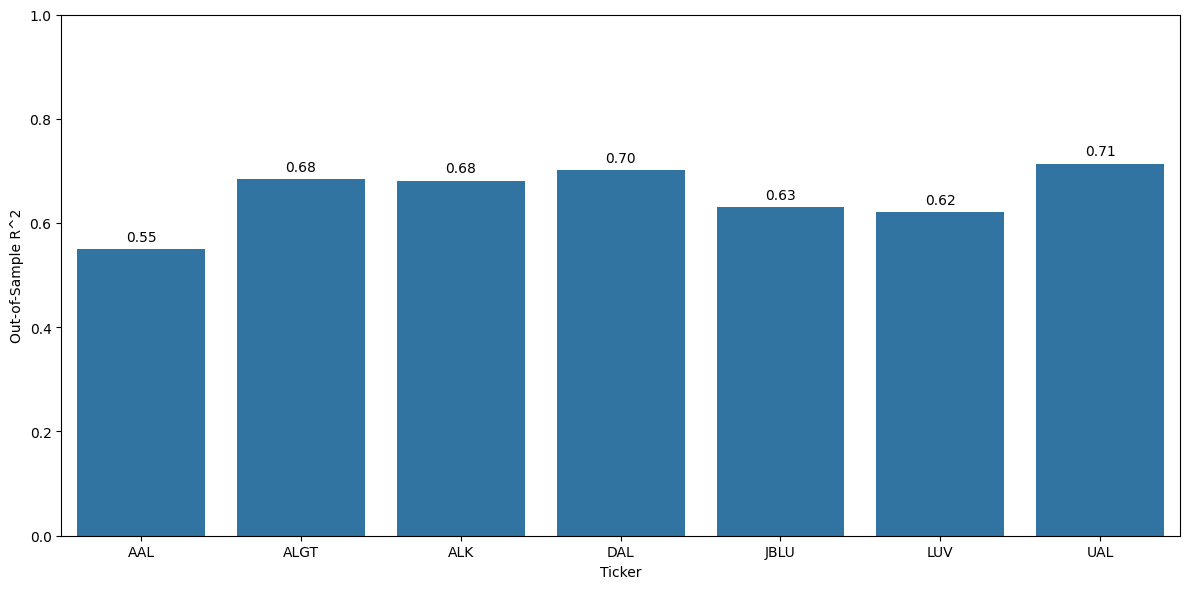

In [68]:
# R2 by ticker for best model
r2_results = {
    'ticker': [],
    'r2': []
}

for ticker in predictions['ticker'].unique():
    ticker_data = predictions[predictions['ticker'] == ticker]
    r2_val = r2(ticker_data['Actual'], ticker_data['Predicted (LightGBM) (all_tuned_retrained)'])
    
    r2_results['ticker'].append(ticker)
    r2_results['r2'].append(r2_val)

# Bar chart with sns
import seaborn as sns
r2_df = pd.DataFrame(r2_results)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=r2_df, x='ticker', y='r2')
plt.xticks()
plt.xlabel('Ticker')
plt.ylabel('Out-of-Sample R^2')
plt.ylim(0, 1)
plt.tight_layout()
# Add number labels to each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
#plt.savefig('../../output/r2_by_ticker_best_model.png')

In [35]:
# Best model R^2 over time
predictions_agg = predictions.groupby(['date']).agg(
    {'Actual': 'sum', 'Predicted (LightGBM) (all_tuned_retrained)': 'sum'}
)

# Ensure columns are correctly named after aggregation
predictions_agg.columns = ['Actual', 'Predicted (LightGBM) (all_tuned_retrained)']

window = 520 # 5 days of 15-minute data

predictions_agg['reg error'] = (predictions_agg['Actual'] - predictions_agg['Predicted (LightGBM) (all_tuned_retrained)'])**2
predictions_agg['roll_mean'] = predictions_agg['Actual'].rolling(window=window).mean()
predictions_agg['roll_mean_error'] = (predictions_agg['Actual'] - predictions_agg['roll_mean'])**2
predictions_agg['reg error sum'] = predictions_agg['reg error'].rolling(window=window).sum()
predictions_agg['roll_mean_error sum'] = predictions_agg['roll_mean_error'].rolling(window=window).sum()

predictions_agg['rolling_r2'] = 1 - (predictions_agg['reg error sum'] / predictions_agg['roll_mean_error sum'])
# Calculate the rolling R^2
#rolling_r2 = predictions_agg.rolling(window=26).apply(lambda x: r2(x['Actual'], x['Predicted (LightGBM) (all_tuned_retrained)']))
#rolling_r2

predictions_agg['rolling_r2'].plot()

,Actual,Predicted (LightGBM) (all_tuned_retrained),reg error,roll_mean,roll_mean_error,reg error sum,roll_mean_error sum,rolling_r2
date,,,,,,,,
2023-12-04 12:45:00,2453560,2.766656e+06,9.802908e+10,NaN,NaN,NaN,NaN,NaN
2023-12-04 13:00:00,2237619,2.354664e+06,1.369959e+10,NaN,NaN,NaN,NaN,NaN
2023-12-04 13:15:00,3105038,2.265047e+06,7.055846e+11,NaN,NaN,NaN,NaN,NaN
2023-12-04 13:30:00,1920376,2.759008e+06,7.033039e+11,NaN,NaN,NaN,NaN,NaN
2023-12-04 13:45:00,1845965,2.343226e+06,2.472680e+11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-05-30 14:45:00,2848796,2.506701e+06,1.170292e+11,4.037239e+06,1.412396e+12,9.644854e+14,3.788924e+15,0.745446
2025-05-30 15:00:00,3282886,3.113482e+06,2.869757e+10,4.038342e+06,5.707143e+11,9.645079e+14,3.783800e+15,0.745095
2025-05-30 15:15:00,3731410,3.331014e+06,1.603172e+11,4.039977e+06,9.521376e+10,9.645852e+14,3.778992e+15,0.744751


In [59]:
# Best model R^2 over time
predictions_agg = predictions

window = 520 # 5 days of 15-minute data

predictions_agg['reg error'] = (predictions_agg['Actual'] - predictions_agg['Predicted (LightGBM) (all_tuned_retrained)'])**2
predictions_agg['roll_mean'] = predictions_agg.groupby('ticker')['Actual'].rolling(window=window).mean().reset_index(level=0, drop=True)
predictions_agg['roll_mean_error'] = (predictions_agg['Actual'] - predictions_agg['roll_mean'])**2
predictions_agg['reg error sum'] = predictions_agg.groupby('ticker')['reg error'].rolling(window=window).sum().reset_index(level=0, drop=True)
predictions_agg['roll_mean_error sum'] = predictions_agg.groupby('ticker')['roll_mean_error'].rolling(window=window).sum().reset_index(level=0, drop=True)

predictions_agg['rolling_r2'] = 1 - (predictions_agg['reg error sum'] / predictions_agg['roll_mean_error sum'])
# Calculate the rolling R^2
#rolling_r2 = predictions_agg.rolling(window=26).apply(lambda x: r2(x['Actual'], x['Predicted (LightGBM) (all_tuned_retrained)']))
#rolling_r2

predictions_agg

,date,ticker,Actual,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_9,...,Predicted (LightGBM) (finance_time),Predicted (LightGBM) (all),Predicted (LightGBM) (all_tuned),Predicted (LightGBM) (all_tuned_retrained),reg error,roll_mean,roll_mean_error,reg error sum,roll_mean_error sum,rolling_r2
270230,2023-12-04 12:45:00,AAL,1293240,0,0,1,0,0,0,0,...,1.444167e+06,1.398818e+06,1.273039e+06,1.385569e+06,8.524720e+09,NaN,NaN,NaN,NaN,NaN
270231,2023-12-04 12:45:00,ALGT,1447,0,0,1,0,0,0,0,...,5.587949e+03,3.406106e+03,1.775199e+03,3.620900e+03,4.725841e+06,NaN,NaN,NaN,NaN,NaN
270232,2023-12-04 12:45:00,ALK,587333,0,0,1,0,0,0,0,...,3.735391e+05,3.653477e+05,3.965052e+05,3.878293e+05,3.980174e+10,NaN,NaN,NaN,NaN,NaN
270233,2023-12-04 12:45:00,DAL,94989,0,0,1,0,0,0,0,...,1.748006e+05,1.693648e+05,1.612089e+05,1.758026e+05,6.530837e+09,NaN,NaN,NaN,NaN,NaN
270234,2023-12-04 12:45:00,JBLU,273608,0,0,1,0,0,0,0,...,4.896124e+05,4.796478e+05,4.580689e+05,4.958197e+05,4.937805e+10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337783,2025-05-30 15:45:00,ALK,440444,0,0,0,0,0,1,0,...,5.539017e+05,5.802983e+05,5.299487e+05,4.925179e+05,2.711693e+09,71162.615385,1.363687e+11,8.981412e+11,3.336938e+12,0.730849
337784,2025-05-30 15:45:00,DAL,1245698,0,0,0,0,0,1,0,...,1.061786e+06,1.058074e+06,1.242038e+06,1.076072e+06,2.877299e+10,289839.450000,9.136656e+11,1.457696e+13,5.237395e+13,0.721675
337785,2025-05-30 15:45:00,JBLU,8400782,0,0,0,0,0,1,0,...,3.590649e+06,3.451630e+06,3.598861e+06,3.577430e+06,2.326473e+13,978145.571154,5.509553e+13,1.807249e+14,3.849872e+14,0.530569
337786,2025-05-30 15:45:00,LUV,2026886,0,0,0,0,0,1,0,...,1.217692e+06,1.229052e+06,1.449506e+06,1.282050e+06,5.547807e+11,271891.201923,3.080007e+12,1.019212e+13,3.387594e+13,0.699134


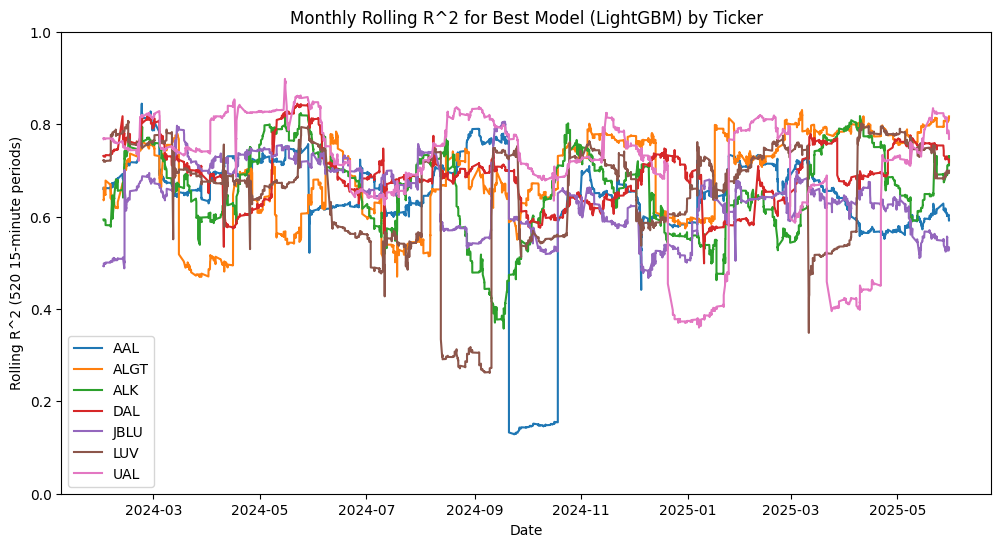

In [60]:
# Plot the rolling R^2 with a separatel line for each ticker
plt.figure(figsize=(12, 6))
for ticker in predictions_agg['ticker'].unique():
    plt.plot(predictions_agg[predictions_agg['ticker'] == ticker]['date'], 
             predictions_agg[predictions_agg['ticker'] == ticker]['rolling_r2'], 
             label=ticker)
plt.ylim(0, 1)
plt.xlabel('Date')
plt.ylabel('Rolling R^2 (520 15-minute periods)')
plt.title('Monthly Rolling R^2 for Best Model (LightGBM) by Ticker')
plt.legend()


<Axes: xlabel='date'>

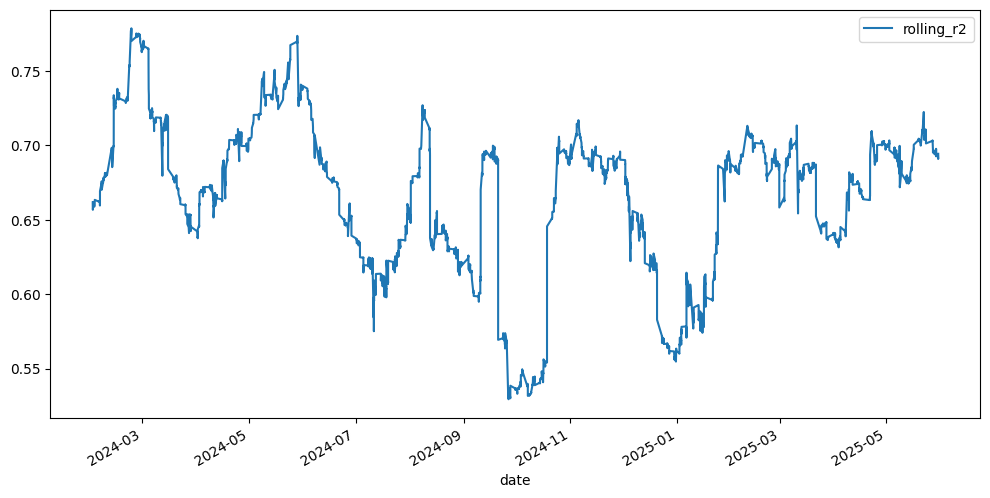

In [53]:
predictions_agg.groupby('date').agg({'rolling_r2': 'mean'}).plot(figsize=(12, 6))

<Axes: xlabel='date'>

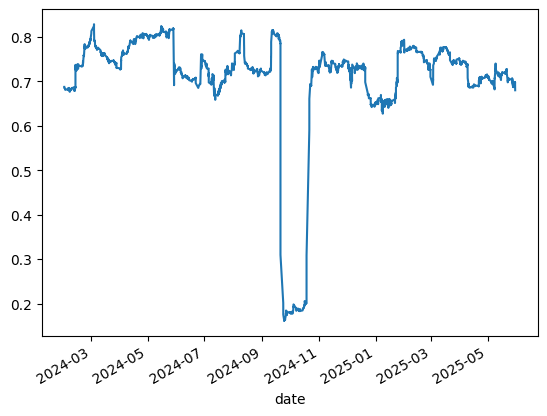

In [49]:
# Best model R^2 over time
predictions_agg = predictions.groupby(['date']).agg(
    {'Actual': 'sum', 'Predicted (OLS) (all)': 'sum'}
)

# Ensure columns are correctly named after aggregation
predictions_agg.columns = ['Actual', 'Predicted (OLS) (all)']

window = 520 # 5 days of 15-minute data

predictions_agg['reg error'] = (predictions_agg['Actual'] - predictions_agg['Predicted (OLS) (all)'])**2
predictions_agg['roll_mean'] = predictions_agg['Actual'].rolling(window=window).mean()
predictions_agg['roll_mean_error'] = (predictions_agg['Actual'] - predictions_agg['roll_mean'])**2
predictions_agg['reg error sum'] = predictions_agg['reg error'].rolling(window=window).sum()
predictions_agg['roll_mean_error sum'] = predictions_agg['roll_mean_error'].rolling(window=window).sum()

predictions_agg['rolling_r2'] = 1 - (predictions_agg['reg error sum'] / predictions_agg['roll_mean_error sum'])
# Calculate the rolling R^2
#rolling_r2 = predictions_agg.rolling(window=26).apply(lambda x: r2(x['Actual'], x['Predicted (LightGBM) (all_tuned_retrained)']))
#rolling_r2

predictions_agg['rolling_r2'].plot()

<Axes: xlabel='date'>

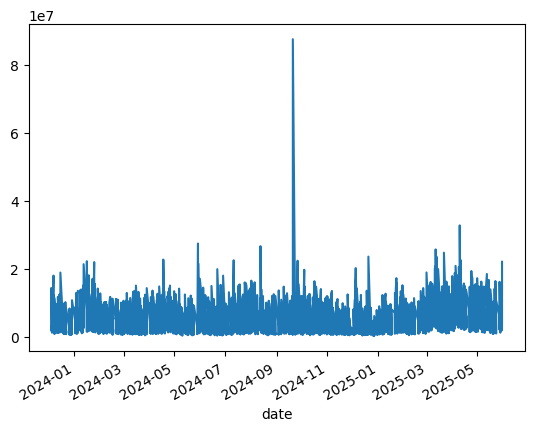

In [50]:
predictions_agg['Actual'].plot()